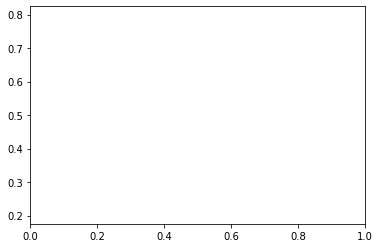

In [1]:
# Setup and import
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt
from math import *

plt.axes().set_aspect('equal', 'datalim')
plt.rcParams['figure.figsize'] = [15, 15]

AbaqusINP = 'Init_Adv'

In [2]:
# READ INITIAL INPUT FILE
# Function to extract nodal coordinates
def readINPUT(AbaqusINP):
    # Open file to read and write
    linesINP = open(AbaqusINP+".inp",'r')
    nodeInf = open(AbaqusINP+"NodeInf.txt",'w')
    
    # Read lines in initial input file and collect info
    for line in linesINP:
        if '*Node' in line:
            for line in linesINP:
                if '*Node' in line:
                    continue
                elif line.startswith('*Element, type=CPS4'): # It should be checked what types of element is used
                    linesINP.close()
                    nodeInf.close()
                    return

                nodeInf.write(line)

In [3]:
# Load Coordinates into NumPy Array
readINPUT(AbaqusINP)
coords = np.loadtxt(AbaqusINP+"NodeInf.txt", delimiter=',')

# Print to ensure the file was actually loaded
print(coords)

[[ 1.00000000e+00 -8.12132034e+01 -2.12132034e+01]
 [ 2.00000000e+00 -1.53693176e+02 -9.36931686e+01]
 [ 3.00000000e+00 -6.00000000e+01 -1.69705627e+02]
 ...
 [ 1.23500000e+04  9.04647827e+01  1.07785133e+02]
 [ 1.23510000e+04  8.86656647e+01  1.08466629e+02]
 [ 1.23520000e+04  8.68038177e+01  1.09246170e+02]]


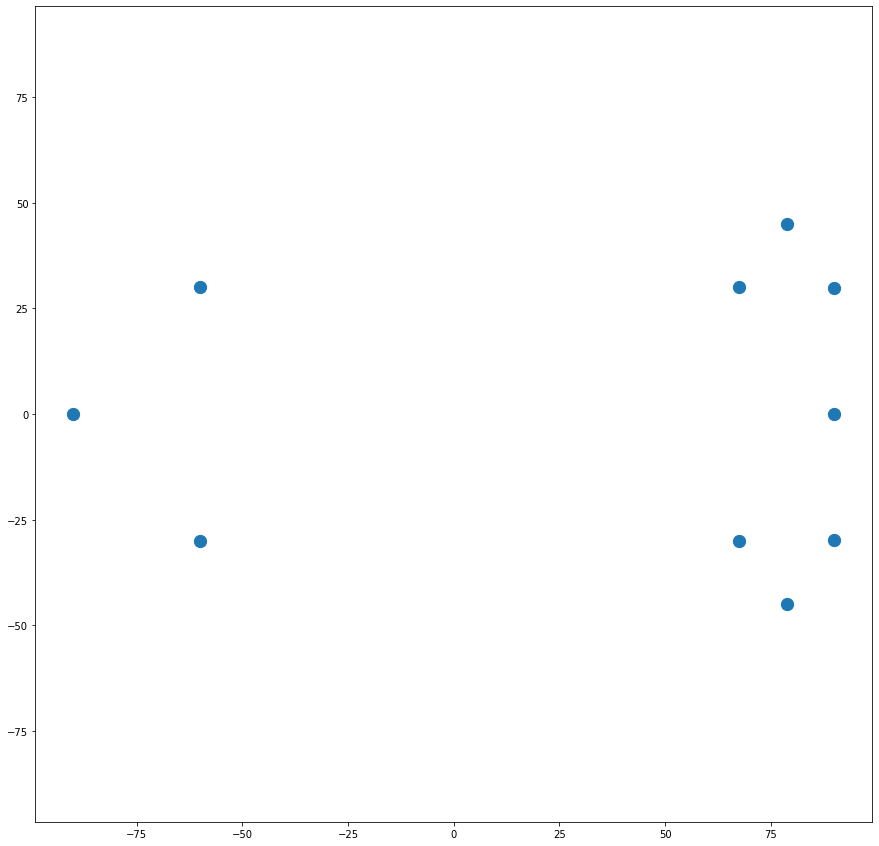

In [4]:
# Define Significant Points - distal points on the flap
P1 = np.array([-90., 0.])
P2 = np.array([-60., -30.])
P3 = np.array([67.5, -30.])
P4 = np.array([78.75, -45.])
P5 = np.array([90., -29.9])
P6 = np.array([90., 0.])
P7 = np.array([-60., 30.])
P8 = np.array([67.5, 30.])
P9 = np.array([78.75, 45.])
P10 = np.array([90., 29.9])

# Plot points to ensure accuracy
x1, y1 = np.array([P1, P2, P3, P4, P5, P6, P7, P8, P9, P10]).T
plt.axis('equal')
plt.scatter(x1, y1, s = 150)


In [5]:
# OBTAIN POINTS TO FIX THE EDGE OF THE FLAP
# Initialize lists
inside = [] # For plotting
outside = [] # For plotting
fix = [] # For updating input file
free = [] # For output to a text file to read results from Abaqus outputs

#Iterate through coordinates
for coord in coords:
    # Grab a coordinate
    xi, yi = float(coord[1]), float(coord[2])
    edge = np.linalg.norm(np.array([0., 0.])-np.array([xi, yi]))
    if abs(edge - 180.) >= 0.1: 
        inside.append([xi, yi])
        free.append(coord[0])
    else:
        outside.append([xi, yi])
        fix.append(coord[0])
    

(-199.53312860241977,
 199.53312860241982,
 -199.56984229979986,
 199.56984229979986)

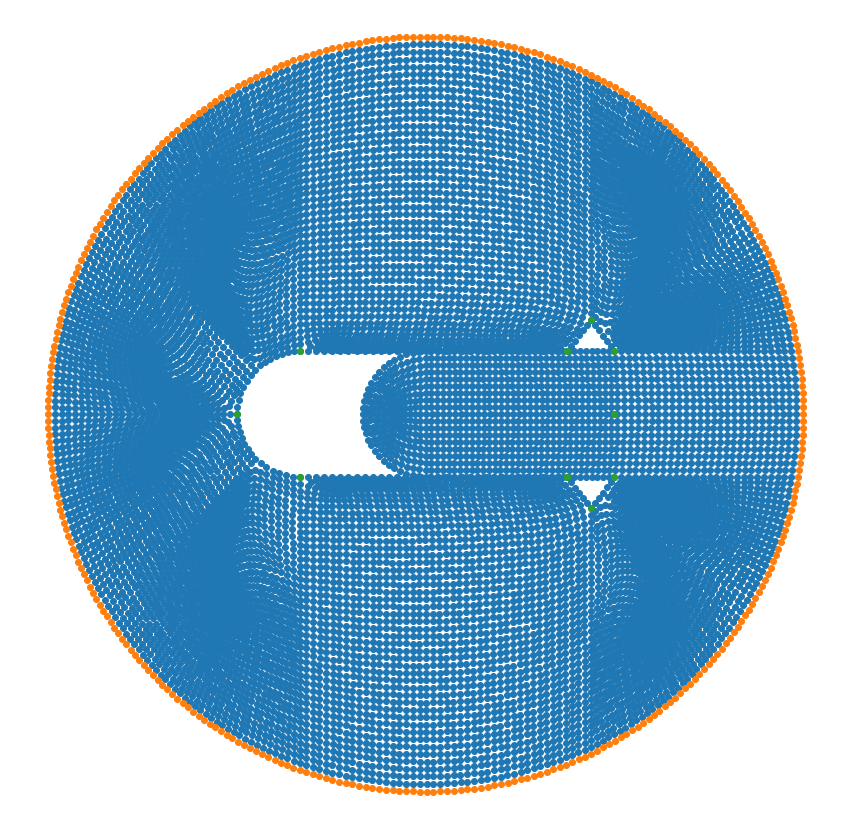

In [6]:
# Plot fixed points in orange and unfixed points in blue to confirm accuracy
# Also plot  points of interest
x, y = np.array(inside).T
xout, yout =np.array(outside).T
plt.scatter(x, y)
plt.scatter(xout, yout)
plt.scatter(x1, y1)
plt.axis('off')
plt.axis('equal')

In [7]:
# Output free nodes to a text file - this is used to know what parts of the abaqus output correspond to which nodes here
with open('adv60_12500.txt', 'w') as f:
    for n in free:
        f.write("%d\n" % n)

# Also output all of the nodes
with open('adv60_12500_all.txt', 'w') as f:
    for i in range(1, len(coords) + 1):
        f.write("%d\n" % i)

In [8]:
# LOCATE THE EDGES OF THE FLAP GEOMETRY FOR STITCHING
# Define distances
d_small = 29.9 # Defect Radius minus 0.1
d_large = 30.0 # Defect Radius 
# Find the points on the edges of the flap needed for stitching
# Define lists to store coordinates and node numbers
outerxCIRC, outeryCIRC = [], []
innerxCIRC, inneryCIRC = [], []
outerxLINE_UP, outeryLINE_UP = [], []
innerxLINE_UP, inneryLINE_UP = [], []
outerxLINE_LO, outeryLINE_LO = [], []
innerxLINE_LO, inneryLINE_LO = [], []
outerxTRI_UP, outeryTRI_UP = [], []
innerxTRI_UP, inneryTRI_UP = [], []
outerxTRI_LO, outeryTRI_LO = [], []
innerxTRI_LO, inneryTRI_LO = [], []
oNodeCIRC, iNodeCIRC = [], []
oNodeLINE_UP, iNodeLINE_UP = [], []
oNodeTRI_UP, iNodeTRI_UP = [], []
oNodeLINE_LO, iNodeLINE_LO = [], []
oNodeTRI_LO, iNodeTRI_LO = [], []


# Iterate through coordinates to find stitch points
for coord in coords:
    # Grab a coordinate
    nodei, xi, yi = float(coord[0]), float(coord[1]), float(coord[2])
    
    # Only check the coordinate if it's x value is between P1 and P6
    if xi >= P1[0] and yi <= P6[0]:
        
        # Define perimeter of the 2 quarter circles
        circle1 = (xi+d_large*2)**2. + (yi-0)**2. - d_large**2 
        circle2 = (xi)**2. + (yi)**2. - d_small**2.
        
        # Define left line of lower triangle
        points = [P3,P4]
        x_coords, y_coords = zip(*points)
        A = np.vstack([x_coords,np.ones(len(x_coords))]).T
        m, c = np.linalg.lstsq(A, y_coords)[0]
        line1 = m * xi + c
        
        # Define right line of lower triangle
        points = [P5,P4]
        x_coords, y_coords = zip(*points)
        A = np.vstack([x_coords,np.ones(len(x_coords))]).T
        m, c = np.linalg.lstsq(A, y_coords)[0]
        line2 = m * xi + c
        
        # Define left line of upper triangle
        points = [P8,P9]
        x_coords, y_coords = zip(*points)
        A = np.vstack([x_coords,np.ones(len(x_coords))]).T
        m, c = np.linalg.lstsq(A, y_coords)[0]
        line3 = m * xi + c
        
        # Define right line of lower triangle
        points = [P10,P9]
        x_coords, y_coords = zip(*points)
        A = np.vstack([x_coords,np.ones(len(x_coords))]).T
        m, c = np.linalg.lstsq(A, y_coords)[0]
        line4 = m * xi + c
        
        # Determine if point is on outer half circle perimeter
        if xi <= P2[0] and circle1 <= 0.1:
            outerxCIRC.append(xi)
            outeryCIRC.append(yi)
            oNodeCIRC.append(nodei)
            
        # Determine if point is on lower outer flat line
        elif xi > P2[0] and xi <= P3[0] and abs(yi+d_large) <= 0.01:
            outerxLINE_LO.append(xi)
            outeryLINE_LO.append(yi)
            oNodeLINE_LO.append(nodei)
            
        # Determine if point is on upper outer flat line
        elif xi > P7[0] and xi <= P8[0] and abs(yi-d_large) <= 0.01:
            outerxLINE_UP.append(xi)
            outeryLINE_UP.append(yi)
            oNodeLINE_UP.append(nodei)
            
        # Determine if point is on inner half circle perimeter
        elif xi >= -1*d_small and xi <= 0 and circle2 <= 0.01 and circle2 >= -0.10:
            innerxCIRC.append(xi)
            inneryCIRC.append(yi)
            iNodeCIRC.append(nodei)
            
        # Determine if point is on lower inner flat line
        elif xi > -1*d_small and xi <= P5[0] and abs(yi + d_small) <= 0.01:
            innerxLINE_LO.append(xi)
            inneryLINE_LO.append(yi)
            iNodeLINE_LO.append(nodei)
            
        # Determine if point is on upper inner flat line
        elif xi > -1*d_small and xi <= P10[0] and abs(yi-d_small) <= 0.01:
            innerxLINE_UP.append(xi)
            inneryLINE_UP.append(yi)
            iNodeLINE_UP.append(nodei)
            
        # Determine if point is on left line of lower triangle
        elif xi >= P3[0] and xi < P4[0] and abs(line1 - yi) <= 0.01 and yi > P4[1]:
            outerxTRI_LO.append(xi)
            outeryTRI_LO.append(yi)
            oNodeTRI_LO.append(nodei)
            
        # Determine if point is on the left line of upper triangle
        elif xi >= P8[0] and xi < P10[0] and abs(line3 - yi) <= 0.01 and yi < P9[1]:
            outerxTRI_UP.append(xi)
            outeryTRI_UP.append(yi)
            oNodeTRI_UP.append(nodei)
            
        # Determine if point is on right line of lower triangle
        elif xi > P4[0] and xi <= P5[0] and abs(line2-yi)<= 0.01 and yi > P4[1]: #CHECK
            innerxTRI_LO.append(xi)
            inneryTRI_LO.append(yi)
            iNodeTRI_LO.append(nodei)
            
        # Determine if point is on the right line of upper triangle
        elif xi > P9[0] and xi <= P10[0] and abs(line4-yi) <= 0.01 and yi < P9[1]:
            innerxTRI_UP.append(xi)
            inneryTRI_UP.append(yi)
            iNodeTRI_UP.append(nodei)
  

C:\Users\casey\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
C:\Users\casey\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
C:\Users\casey\Anaconda3\lib\site-packages\ipykernel_launcher.py:54: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`

(-199.53312860241977,
 199.53312860241982,
 -199.56984229979986,
 199.56984229979986)

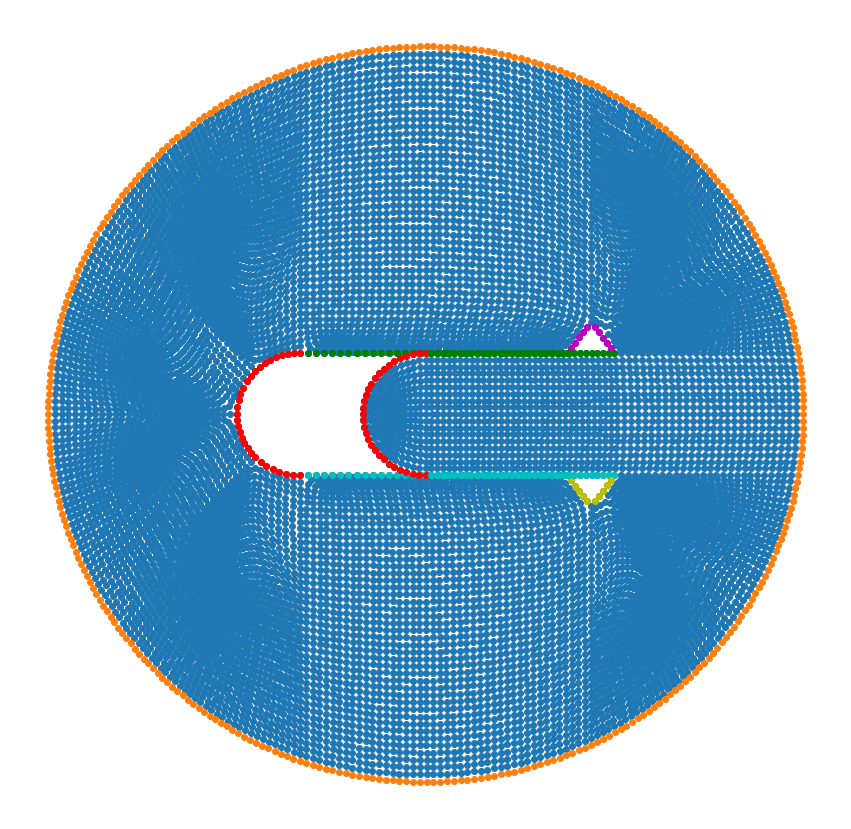

In [9]:
# Plot the results of the stitch points
# Each quarter circle, flat line, and triangle segment should be a different color
plt.scatter(x, y)
plt.scatter(xout, yout)
plt.scatter(outerxCIRC, outeryCIRC, c='r')
plt.scatter(outerxLINE_LO, outeryLINE_LO, c='c')
plt.scatter(outerxLINE_UP, outeryLINE_UP, c='g')
plt.scatter(outerxTRI_LO, outeryTRI_LO, c='y')
plt.scatter(outerxTRI_UP, outeryTRI_UP, c='m')
plt.scatter(innerxCIRC, inneryCIRC, c='r')
plt.scatter(innerxLINE_LO, inneryLINE_LO,  c='c')
plt.scatter(innerxLINE_UP, inneryLINE_UP, c='g')
plt.scatter(innerxTRI_LO, inneryTRI_LO, c='y')
plt.scatter(innerxTRI_UP, inneryTRI_UP, c='m')
plt.axis('off')


In [10]:
# PAIR NODES FOR STITCHING
# **NOTE**: The segements need to have equal numbers of nodes
# Function to do this
def pairStitches(iNode, oNode, innerx, innery, outerx, outery, segment):
    # Collect distances between paired nodes (for defining boundary conditions), and the two sets of nodes to pair
    distances = []
    stitchO = []
    stitchI = []
    
    # Triangular segment
    if (segment == 'tri'):
        # Sort the inner nodes nodes and points in order of increasing x coordinates
        iNode = [x for _,x in sorted(zip(innerx,iNode))]
        innery = [x for _,x in sorted(zip(innerx,innery))]
        innerx = sorted(innerx)
        
        # Starting with the lowest x coordinate, pair with the node on the other segment that is closest
        for i in range(0, len(innerx)):
            xinner, yinner = innerx[i], innery[i]
            node = iNode[i]
            nodeStitch = 0;
            distanceBest = 10.**10.
            for j in range(0, len(outerx)):
                xouter, youter = outerx[j], outery[j]
                distance = sqrt((xouter - xinner)**2. + (youter - yinner)**2.)
                if distance < distanceBest:
                    distanceBest = distance
                    nodeStitch = oNode[j]
                    index = j
            outerx.pop(index)
            outery.pop(index)
            oNode.pop(index)
            
            stitchI.append(node)
            stitchO.append(nodeStitch)
            distances.append(distanceBest)
    
    # Line segment
    elif (segment == 'line'): 
        # Sort in order of increasing x coordinate
        oNode = [x for _,x in sorted(zip(outerx,oNode))]
        outery = [x for _,x in sorted(zip(outerx,outery))]
        outerx = sorted(outerx) 
        
        # Pair to the closest node
        for i in range(0, len(outerx)):
            xouter, youter = outerx[i], outery[i]
            node = oNode[i]
            nodeStitch = 0;
            distanceBest = 10**10.
            for j in range(0, len(innerx)):
                xinner, yinner = innerx[j], innery[j]
                distance = sqrt((xouter - xinner)**2. + (youter - yinner)**2.)
                if distance < distanceBest:
                    distanceBest = distance
                    nodeStitch = iNode[j]
                    index = j
            innerx.pop(index)
            innery.pop(index)
            iNode.pop(index)

            stitchO.append(node)
            stitchI.append(nodeStitch)
            distances.append(distanceBest)
    
    # Circle segment
    elif (segment=='circ'): 
        iNode = [x for _,x in sorted(zip(innerx,iNode))]
        innery = [x for _,x in sorted(zip(innerx,innery))]
        innerx = sorted(innerx)
        for i in range(len(innerx)-1,-1,-1):
            xinner, yinner = innerx[i], innery[i]
            node = iNode[i]
            nodeStitch = 0;
            distanceBest = 10.**10.
            for j in range(0, len(outerx)):
                xouter, youter = outerx[j], outery[j]
                distance = sqrt((xouter - xinner)**2. + (youter - yinner)**2.)
                if distance < distanceBest:
                    distanceBest = distance
                    nodeStitch = oNode[j]
                    index = j
            outerx.pop(index)
            outery.pop(index)
            oNode.pop(index)
            
            stitchI.append(node)
            stitchO.append(nodeStitch)
            distances.append(distanceBest)
            
    # Just in case you spelled something wrong
    else:
        print('That segment doesnt exist')
        
    return [stitchO, stitchI, distances]

# Perform all the pairing
[stitchO_LINE_UP, stitchI_LINE_UP, distances_LINE_UP] = pairStitches(iNodeLINE_UP, oNodeLINE_UP, innerxLINE_UP, inneryLINE_UP, outerxLINE_UP, outeryLINE_UP, 'line')
[stitchO_LINE_LO, stitchI_LINE_LO, distances_LINE_LO] = pairStitches(iNodeLINE_LO, oNodeLINE_LO, innerxLINE_LO, inneryLINE_LO, outerxLINE_LO, outeryLINE_LO, 'line')
[stitchO_TRI_UP, stitchI_TRI_UP, distances_TRI_UP] = pairStitches(iNodeTRI_UP, oNodeTRI_UP, innerxTRI_UP, inneryTRI_UP, outerxTRI_UP, outeryTRI_UP, 'tri')
[stitchO_TRI_LO, stitchI_TRI_LO, distances_TRI_LO] = pairStitches(iNodeTRI_LO, oNodeTRI_LO, innerxTRI_LO, inneryTRI_LO, outerxTRI_LO, outeryTRI_LO, 'tri')
[stitchO_CIRC, stitchI_CIRC, distances_CIRC] = pairStitches(iNodeCIRC, oNodeCIRC, innerxCIRC, inneryCIRC, outerxCIRC, outeryCIRC, 'circ')
    
# Create an overarching pair set
stitchO = np.concatenate((stitchO_CIRC, stitchO_LINE_UP, stitchO_LINE_LO, stitchO_TRI_UP, stitchO_TRI_LO))
stitchI = np.concatenate((stitchI_CIRC, stitchI_LINE_UP, stitchI_LINE_LO, stitchI_TRI_UP, stitchI_TRI_LO))
distances = np.concatenate((distances_CIRC, distances_LINE_UP, distances_LINE_LO, distances_TRI_UP, distances_TRI_LO))


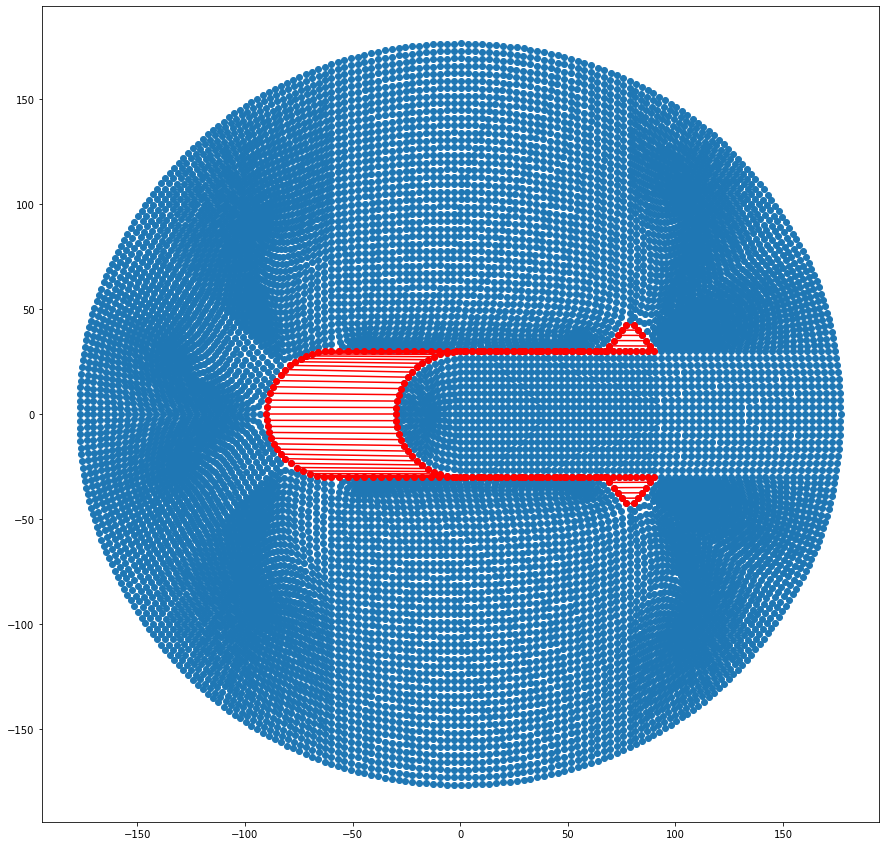

In [11]:
# Plot the stiching pairs
plt.scatter(x, y)
for i in range(0, len(stitchI)):
    plt.plot([coords[int(stitchO[i]) - 1][1],  coords[int(stitchI[i]) - 1][1]], [coords[int(stitchO[i]) - 1][2],  coords[int(stitchI[i]) - 1][2]], 'ro-')


In [12]:
# WRITE TO THE NEW INPUT FILE
# Open and read in base input file
linesINP = open(AbaqusINP+".inp",'r')
i = 0
lines = []

# Figure out where the end part line is
for line in linesINP:
    lines.append(line)
    if line == '*End Part\n':
        endPart = i
    i += 1

# Close base inputs file
linesINP.close()

In [13]:
# Determine how many nodes and elements you have
for i in range(0, len(lines)):
    if lines[i][0:8] == '*Element':
        break
n_nodes = int(lines[i-1].strip().split(',')[0])

# Get total number of elements
for i in range(0, len(lines)):
    if lines[i] == '*End Part\n':
        break
n_elems_1 = int(lines[i-1].strip().split(',')[0])

for i in range(0, len(lines)):
    if lines[i] == '*Element, type=CPS3\n':
        break
n_elems_2 = int(lines[i-1].strip().split(',')[0])

n_elems = max(n_elems_1, n_elems_2)

# Confirm you got the right numbers
print(n_elems)
print(n_nodes)

# Build overall node and element sets
sets = ['*Nset, nset=Set-1, generate\n']
sets.append('1,'+str(n_nodes) + ', 1\n')
sets.append('*Elset, elset=SKIN_element, generate\n')
sets.append('1,'+str(n_elems) + ', 1\n')

# Insert the new lines, adjusting i to know where the end of the files is
i = endPart
for set in sets:
    lines.insert(i, set)
    i += 1

12073
12352


In [14]:
# Add material parameters for skin
# Define these lines
skinParams = ['**\n', 
              '*ORIENTATION, NAME=ORI\n', 
              '-0.9885573278588885, 0.15084564805288259, 0., -0.15084564805288259, -0.9885573278588885, 0.\n', 
              '3, 0.\n', 
              '*SOLID SECTION, ELSET=SKIN_element, MATERIAL=SKIN_HOLZ, ORIENTATION=ORI\n']

# Add these parameters, again adjusting i
for param in skinParams:
    lines.insert(i, param)
    i += 1

In [15]:
# Create connectors for stitches
instname = 'advflap-1'

# Locate the end of the assembly
for i in range(0, len(lines)):
    if lines[i] == '*End Assembly\n':
        endAssem = i
        break
        
# Initialize the connector set
connectors = ['**\n', '*Element, type=CONN2D2\n']

# Use the overall stitching sets to create the connectors
for i in range(0, len(stitchO)):
   connectors.append(str(i+1) + ', ' + instname + '.' + str(int(stitchO[i])) + ', ' + instname + '.' + str(int(stitchI[i])) + '\n')

# Adjust i
i = endAssem - 1
for conn in connectors:
    lines.insert(i, conn)
    i += 1

# Create a section for the connectors
lines.insert(i, '*Connector Section, elset=Set-2\n')
lines.insert(i+1, 'Axial,\n')

In [16]:
#Create node set for skin
for i in range(0, len(lines)):
    if lines[i] == 'Axial,\n':
        endConSec = i
        break
nset = ['*Nset, nset=SKINNODE, instance=' + instname + '\n']

# Add lines for this node set, putting 15 nodes per line
j = 0
nline = ' '
for i in range(1, len(coords)+1, 1):
    if j == 15 or i == len(coords):
        nline = nline + str(i) + '\n'
        nset.append(nline)
        j = 1
        nline = ' '
    else:
        nline = nline + str(i) + ', '
        j += 1

# Add lines
i = endConSec + 1
for n in nset:
    lines.insert(i, n)
    i += 1

In [17]:
# Create wire sets for the stitches
# Figure out where the node set ends
for i in range(0, len(lines)):
    if lines[i] == nset[-1]:
        endNset = i
        break
        
# Create wires, similar to connectors
wires = []
for i in range(0, len(stitchO)):
    wires.append('*Nset, nset=WIRE-' + str(i+1) + ', instance=' + instname + '\n')
    wires.append(' ' + str(int(stitchO[i])) + ', ' + str(int(stitchI[i])) + '\n')

# Add lines
i = endNset + 1
for wire in wires:
    lines.insert(i, wire)
    i += 1


In [18]:
# Create node set for fixed nodes
# Figure out where the wires end
for i in range(0, len(lines)):
    if lines[i] == wires[-1]:
        endWires = i
        break

# Write out node set, 15 nodes per line
nset = ['*Nset, nset=fix, internal, instance=' + instname + '\n']
fix = sorted(fix)
j = 0
nline = ' '
for i in range(0, len(fix), 1):
    if j == 15 or i == len(fix)-1:
        nline = nline + str(int(fix[i])) + '\n'
        nset.append(nline)
        j = 1
        nline = ' '
    else:
        nline = nline + str(int(fix[i])) + ', '
        j += 1

# Add to the file
i = endWires + 1
for n in nset:
    lines.insert(i, n)
    i += 1

In [19]:
# Create element sets 
for i in range(0, len(lines)):
    if lines[i] == nset[-1]:
        endSet = i
        break

# Initialize element set
elSet = ['*Elset, elset=Set-2, internal, generate\n']
elSet.append('1, ' + str(int(len(distances))) + ', 1\n') 

# Add for each stitch
n = 1
for i in range(1, len(distances)+1):
    elSet.append('*Elset, elset=_PickedSet'+str(int(n))+', internal\n')
    elSet.append(' ' + str(int(i))+',\n')
    n += 1
    
# Add to file
i = endSet + 1
for el in elSet:
    lines.insert(i, el)
    i+=1

In [20]:
# Add material parameters
matParams = ['**\n', 
             '** MATERIALS\n',
             '**\n',
             '*Material, name=SKIN_HOLZ\n',
             '*Anisotropic Hyperelastic, holzapfel, local direction=1\n',
             '0.051376, 0.0005, 21.157203, 60.480896, 0.252729\n',
             '**22.49,  0.0005, 4909.2,  76.641,  0.1\n',
             '** C10, D, k1, k2, kappa\n',
             '**DISTRIBUTION TABLE, NAME=DISTORI_TABLE\n',
             '**COORD3D,COORD3D\n',
             '**DISTRIBUTION TABLE, NAME=ANGLETABLE\n',
             '**ANGLE\n']
for param in matParams:
    lines.append(param)
             

In [21]:
# Boundary conditions - Fix nodes
fixConditions = ['**\n',
                 '**BOUNDARY CONDITIONS\n',
                 '**\n',
                 '** Name: fixednodes Type: Symmetry/Antisymmetry/Encastre\n'
                '*BOUNDARY\n',
                'fix, ENCASTRE\n',
                '**\n']
for condition in fixConditions:
    lines.append(condition)

In [22]:
# Boundary conditions -  Step 1 - the circle bit
step_1 = ['**\n',
         '** ----------------------------------------------------------------\n',
         '**\n',
         '** STEP: Step-1\n',
         '**\n',
         '*Step, name=Step-1, nlgeom=YES, inc=1000\n',
         '*Static\n',
         '0.1, 1., 1e-07, 1.\n',
         '**\n',
         '**BOUNDARY CONDITIONS\n',
         '**\n']

# Define connector motion
n = 1
for i in range(len(distances_CIRC)):
    step_1.append('** Name: ConnDisp-BC-'+ str(int(n)) + ' Type: Connector displacement\n')
    step_1.append('*Connector Motion\n')
    step_1.append('_PickedSet'+str(int(n))+', 1, -'+str(floor(distances[i]*10)/10)+'\n')
    n+=1
endN = n

# Add step 1 to file
for line in step_1:
    lines.append(line)
    
# Add output requests for this step
outputs = ['**\n',
           '** OUTPUT REQUESTS\n',
           '**\n',
           '*Restart, write, frequency=0\n',
           '**\n',
           '** FIELD OUTPUT: F-Output-1\n',
           '**\n',
           '*Output, field\n',
           '*Contact Output\n',
           'CDISP, CSTRESS\n',
           '**\n',
           '** FIELD OUTPUT: F-Output-2\n',
           '**\n',
           '*Node Output\n',
           'CF, COORD, RF, U\n',
           '**\n',
           '** FIELD OUTPUT: F-Output-3\n',
           '**\n',
           '*Element Output, directions=YES\n',
           'EVOL, IVOL, LE, PE, PEEQ, PEMAG, S, SVOL\n',
           '**\n',
           '** HISTORY OUTPUT: H-Output-1\n',
           '**\n',
           '*Output, history, variable=PRESELECT\n',
           '*End Step\n']
for output in outputs:
    lines.append(output)


In [23]:
# Step 2 - line and triangle parts
# Initialize boundary conditions
step_2 = ['**\n',
         '** ----------------------------------------------------------------\n',
         '**\n',
         '** STEP: Step-2\n',
         '**\n',
         '*Step, name=Step-2, nlgeom=YES, inc=1000\n',
         '*Static\n',
         '0.1, 1., 1e-07, 1.\n',
         '**\n',
         '**BOUNDARY CONDITIONS\n',
         '**\n']

# Define connector motion
n = endN
for i in range(len(distances_LINE_UP)+len(distances_LINE_LO)+len(distances_TRI_UP)+len(distances_TRI_LO)):
    step_2.append('** Name: ConnDisp-BC-'+ str(int(n)) + 'Type: Connector displacement\n')
    step_2.append('*Connector Motion\n')
    step_2.append('_PickedSet'+str(int(n))+', 1, -'+str(floor(distances[n-1]*10)/10)+'\n')
    n+=1

# Add to file
for line in step_2:
    lines.append(line)
    
# Create output requests
outputs = ['**\n',
           '** OUTPUT REQUESTS\n',
           '**\n',
           '*Restart, write, frequency=0\n',
           '**\n',
           '** FIELD OUTPUT: F-Output-4\n',
           '**\n',
           '*Output, field\n',
           '*Contact Output\n',
           'CDISP, CSTRESS\n',
           '**\n',
           '** FIELD OUTPUT: F-Output-5\n',
           '**\n',
           '*Node Output\n',
           'CF, COORD, RF, U\n',
           '**\n',
           '** FIELD OUTPUT: F-Output-6\n',
           '**\n',
           '*Element Output, directions=YES\n',
           'EVOL, IVOL, LE, PE, PEEQ, PEMAG, S, SVOL\n',
           '**\n',
           '** HISTORY OUTPUT: H-Output-2\n',
           '**\n',
           '*Output, history, variable=PRESELECT\n',
           '*End Step\n']
for output in outputs:
    lines.append(output)


In [24]:
# Write new input file
with open('Base_Advancement.inp', 'w') as f:
    for line in lines:
        f.write("%s" % line)